# Preparation

> Import libraries used

In [31]:
!pip install squarify

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [32]:
# link to data: https://docs.google.com/spreadsheets/d/1yNt8-kkoDyYzq8tYbqWRqqrAfyhPNtBlfSo-9aRvbCY/view
data_link='1yNt8-kkoDyYzq8tYbqWRqqrAfyhPNtBlfSo-9aRvbCY'
data = gc.open_by_key(data_link)

order_info = pd.DataFrame(data.worksheet('ecommerce retail').get_all_records())
segmentation = pd.DataFrame(data.worksheet('Segmentation').get_all_records())

print(order_info.head())
print('\n', segmentation.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/10 8:26       2.55      17850  United Kingdom  
1  12/1/10 8:26       3.39      17850  United Kingdom  
2  12/1/10 8:26       2.75      17850  United Kingdom  
3  12/1/10 8:26       3.39      17850  United Kingdom  
4  12/1/10 8:26       3.39      17850  United Kingdom  

               Segment                                          RFM Score
0           Champions                  555, 554, 544, 545, 454, 455, 445
1               Loyal             543, 444, 435, 355, 354, 345, 344, 335
2  Potenti

# Data cleaning

## Check

### Segmentation

In [33]:
segmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Segment    11 non-null     object
 1   RFM Score  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


In [34]:
segmentation.duplicated().sum()

0



> there no duplicate or null value in segmentation, we just need to explode the RFM Score column



### Order_info

In [35]:
order_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541909 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [36]:
order_info.duplicated().sum()

5268

In [37]:
order_info['InvoiceNo'].is_unique

False

In [38]:
non_unique_invoices = order_info[order_info.duplicated('InvoiceNo', keep=False)]
print(non_unique_invoices)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

          InvoiceDate  UnitPrice CustomerID         Country  
0        12/1

> There no null value with .info function, but there might be hidden missing value for the object dtype!

> InvoiceNo not unqiue because an order seperated by each product within it, which not a problem. Also we have to remove cancel order (start with C)

> Beside we also to check values of each column that not match as follow:

. ListStockCode: Product (item) code. Nominal, is a 5-digit integral number uniquely assigned to each distinct product.

. Description: Product (item) name. Nominal.

. Quantity: The quantities of each product (item) per transaction. Numeric.

. InvoiceDate: Invoice Date and time. The numeric is the day and time when each transaction was generated.

. UnitPrice: Unit price. Numeric, the product price per unit is in sterling.

. CustomerID: Customer number. Nominal, is a 5-digit integral number uniquely assigned to each customer.

. Country: Country name. Nominal, is the name of the country where each customer resides.

In [39]:
# Check values in remaining cols not match the usual

# Check StockCode: should be a 5-digit integer
strange_stockcode = order_info[~order_info['StockCode'].astype(str).str.match(r'^\d{5}$')]

# Check Empty Description
empty_description = order_info[(order_info['Description'] == '')]

# Wrong Quantity: numeric and not negative
wrong_quantity = order_info[order_info['Quantity'] <= 0]

# Check InvoiceDate
invalid_invoicedate = order_info[(order_info['InvoiceDate'] == '')]

# Check UnitPrice: numeric and not negative
wrong_unitprice = order_info[order_info['UnitPrice'] <= 0]

# Check CustomerID: should be a 5-digit integer
strange_customerid = order_info[~order_info['CustomerID'].astype(str).str.match(r'^\d{5}$')]

# Check Country: should not be empty
empty_country = order_info[(order_info['Country'] == '')]

# Print the results
print("Strange StockCode values:")
print(strange_stockcode)

print("\nEmpty Description values:")
print(empty_description)

print("\nWrong Quantity values:")
print(wrong_quantity)

print("\nInvalid InvoiceDate values:")
print(invalid_invoicedate)

print("\nWrong UnitPrice values:")
print(wrong_unitprice)

print("\nStrange CustomerID values:")
print(strange_customerid)

print("\nEmpty Country values:")
print(empty_country)

Strange StockCode values:
       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
45        536370      POST                              POSTAGE         3   
...          ...       ...                                  ...       ...   
541778    581578    84997C      CHILDRENS CUTLERY POLKADOT BLUE         8   
541809    581579    85099C       JUMBO  BAG BAROQUE BLACK WHITE        10   
541838    581580    84993A            75 GREEN PETIT FOUR CASES         2   
541844    581580    85049A        TRADITIONAL CHRISTMAS RIBBONS         1   
541853    581580    85049E            SCANDINAVIAN REDS RIBBONS         2   

          InvoiceDate  UnitPrice CustomerID      

> On other cols: there actually some hidden missing values

*   Strange stock code: there some value that contain not in 5 digit, but no problem for the whole -> do nothing
*   Empty Description values: Even empty this col not a big problem itself, but when this col empty, there some wrong values in other cols (such as: quantity (negative result), unitprice = 0, empty customer_id) -> handle together with other cols
*   Wrong Quantity values -> drop rows
*   Wrong UnitPrice values -> drop rows
*   Empty CustomerID values -> drop rows
*   InvoiceDate, Country: no problem

> Then we convert dtype to appropriate type

## Clean

### Sengmentation

In [40]:
segmentation.columns = ['segment','score']

segmentation['score'] = segmentation['score'].str.split(',')
segmentation = segmentation.explode('score')

segmentation['score'] = segmentation['score'].str.strip()

segmentation.info()
segmentation['score'].is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 0 to 10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   segment  125 non-null    object
 1   score    125 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


True

In [41]:
segmentation.head()

,segment,score
0,Champions,555
0,Champions,554
0,Champions,544
0,Champions,545
0,Champions,454




> Now each rfm score of df segmentation correspoding with its segment



### Order_info

In [42]:
order_info = order_info.drop_duplicates()

In [43]:
#drop cancel order rows
order_info = order_info[~order_info['InvoiceNo'].astype(str).str.startswith('C')]

#check any row that InvoiceNo not int
non_int_invoice_rows = order_info[~order_info['InvoiceNo'].apply(lambda x: isinstance(x, int))]
print(non_int_invoice_rows)

       InvoiceNo StockCode      Description  Quantity    InvoiceDate  \
299982   A563185         B  Adjust bad debt         1  8/12/11 14:50   
299983   A563186         B  Adjust bad debt         1  8/12/11 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/11 14:52   

        UnitPrice CustomerID         Country  
299982   11062.06             United Kingdom  
299983  -11062.06             United Kingdom  
299984  -11062.06             United Kingdom  




> After remove all cancel order, we still have 3 order of Adjust bad debt. We will delete them because they are not related to this analysis



In [44]:
#remove adjust bad debt order by remove row where InvoiceNo not int
order_info = order_info[order_info['InvoiceNo'].apply(lambda x: isinstance(x, int))]

In [45]:
# Drop rows where Quantity or UnitPrice is negative or 0, or CustomerID is empty
order_info = order_info[
    (order_info['Quantity'] > 0) &
    (order_info['CustomerID'] != '') &
    (order_info['UnitPrice'] > 0)
]

In [46]:
# Check StockCode: should be a 5-digit integer
strange_stockcode = order_info[~order_info['StockCode'].astype(str).str.match(r'^\d{5}$')]

# Check Empty Description
empty_description = order_info[(order_info['Description'] == '')]

# Check CustomerID:
strange_customerid = order_info[~order_info['CustomerID'].astype(str).str.match(r'^\d{5}$')]

# Print the results
print("Strange StockCode values:")
print(strange_stockcode)

print("\nEmpty Description values:")
print(empty_description)

print("\nStrange CustomerID values:")
print(strange_customerid)

Strange StockCode values:
       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
45        536370      POST                              POSTAGE         3   
...          ...       ...                                  ...       ...   
541778    581578    84997C      CHILDRENS CUTLERY POLKADOT BLUE         8   
541809    581579    85099C       JUMBO  BAG BAROQUE BLACK WHITE        10   
541838    581580    84993A            75 GREEN PETIT FOUR CASES         2   
541844    581580    85049A        TRADITIONAL CHRISTMAS RIBBONS         1   
541853    581580    85049E            SCANDINAVIAN REDS RIBBONS         2   

          InvoiceDate  UnitPrice CustomerID      



> After drop missing/wrong values of CustomerID, UnitPrice, Quantity only stockcode have unusual values (not 5 digit). As said, it's not a big problem for the analysis -> do nothing


In [47]:
# Convert InvoiceDate to datetime
order_info['InvoiceDate'] = pd.to_datetime(order_info['InvoiceDate'], format='%m/%d/%y %H:%M', errors='coerce')
# Extract date
order_info['Date'] = order_info['InvoiceDate'].dt.date
order_info['Date'] = order_info['Date'].astype('datetime64[ns]')
#Drop Invoice Date
order_info = order_info.drop(columns=['InvoiceDate'])

order_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   UnitPrice    392692 non-null  float64       
 5   CustomerID   392692 non-null  object        
 6   Country      392692 non-null  object        
 7   Date         392692 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [48]:
# Rename
order_info = order_info.rename(columns={
    'InvoiceNo': 'invoiceid',
    'StockCode': 'stockcode',
    'Description': 'description',
    'Quantity': 'quantity',
    'UnitPrice': 'price',
    'CustomerID': 'customerid',
    'Country': 'country',
    'Date': 'date'
})

order_info.reset_index(drop=True)
order_info.head()

,invoiceid,stockcode,description,quantity,price,customerid,country,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01


# RFM table

In [49]:
# Create Revenue col
order_info['revenue'] = order_info['quantity'] * order_info['price']
order_info.head()

,invoiceid,stockcode,description,quantity,price,customerid,country,date,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,20.34


Calculate Recency (number of day(s) from last order), Frequency (number of orders), and moneytory (the sum of revenue) for each customer id. Also add country for each of them

In [50]:
customer_rfm = order_info.groupby('customerid').agg({'date':'max',
                                         'invoiceid':'nunique',
                                         'revenue':'sum'}).reset_index()
customer_rfm['date'] = (pd.to_datetime('31/12/2011', format='%d/%m/%Y') - customer_rfm['date']).dt.days

customer_rfm.columns = ['customerid','recency','frequency','monetory']

customer_rfm

,customerid,recency,frequency,monetory
0,12346,347,1,77183.60
1,12347,24,7,4310.00
2,12348,97,4,1797.24
3,12349,40,1,1757.55
4,12350,332,1,334.40
...,...,...,...,...
4333,18280,299,1,180.60
4334,18281,202,1,80.82
4335,18282,29,2,178.05
4336,18283,25,16,2045.53


Rank score for Recency, Frenquency, moneytory. Then combine them to RFM_score. And match each customer ID with its score to corresponding segment

In [51]:
#rank customer_rfm from 1 to 5

customer_rfm['r_rank'] = 6 - (pd.qcut(customer_rfm['recency'].rank(method='first'), 5, labels=False) + 1)
customer_rfm['f_rank'] = pd.qcut(customer_rfm['frequency'].rank(method='first'), 5, labels=False) + 1
customer_rfm['m_rank'] = pd.qcut(customer_rfm['monetory'].rank(method='first'), 5, labels=False) + 1

# customer_rfm_score
customer_rfm['score'] = customer_rfm['r_rank'].astype(str) + customer_rfm['f_rank'].astype(str) + customer_rfm['m_rank'].astype(str)

#merge with segmentation
customer_rfm = segmentation.merge(customer_rfm, on ='score', how = 'right')

customer_rfm

,segment,score,customerid,recency,frequency,monetory,r_rank,f_rank,m_rank
0,Cannot Lose Them,115,12346,347,1,77183.60,1,1,5
1,Champions,555,12347,24,7,4310.00,5,5,5
2,At Risk,244,12348,97,4,1797.24,2,4,4
3,Promising,414,12349,40,1,1757.55,4,1,4
4,Lost customers,112,12350,332,1,334.40,1,1,2
...,...,...,...,...,...,...,...,...,...
4333,Lost customers,121,18280,299,1,180.60,1,2,1
4334,Lost customers,121,18281,202,1,80.82,1,2,1
4335,Potential Loyalist,531,18282,29,2,178.05,5,3,1
4336,Champions,554,18283,25,16,2045.53,5,5,4



> Create RFM table by segment



In [52]:
#create rfm table
rfm = customer_rfm.groupby('segment').agg(
    num_ctm=('customerid', 'count'),
    avg_r=('recency', 'mean'),
    avg_f=('frequency', 'mean'),
    sum_rvn=('monetory', 'sum')
).round(1).reset_index()

rfm

,segment,num_ctm,avg_r,avg_f,sum_rvn
0,About To Sleep,286,107.6,1.3,78871.6
1,At Risk,429,164.0,3.8,760380.2
2,Cannot Lose Them,93,258.1,2.3,205676.5
3,Champions,832,32.8,12.1,5587745.7
4,Hibernating customers,691,171.2,1.6,282393.0
5,Lost customers,489,296.3,1.1,97313.4
6,Loyal,423,57.6,5.3,1009706.0
7,Need Attention,285,54.7,3.1,465431.6
8,New Customers,268,49.8,1.1,59674.9
9,Potential Loyalist,409,48.2,2.5,220916.5


# Analysis

In [53]:
rfm['%_ctm'] = round((rfm['num_ctm'] / rfm['num_ctm'].sum()) * 100, 1)
rfm['%_rvn'] = round((rfm['sum_rvn'] / rfm['sum_rvn'].sum()) * 100, 1)
color = sns.color_palette("RdYlGn_r", len(rfm))

Calculate Precennt in total of:

* Average of Recency & Frequency
* Sum of Moneytory of each Segment



<ipython-input-54-e8e1933cfb4c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm['segment'], y=rfm[col], palette=color, legend = False)


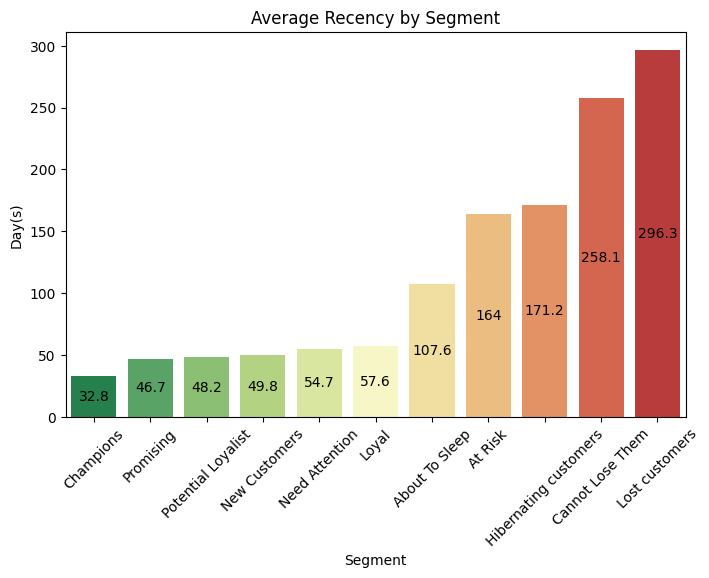

<ipython-input-54-e8e1933cfb4c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm['segment'], y=rfm[col], palette=color, legend = False)


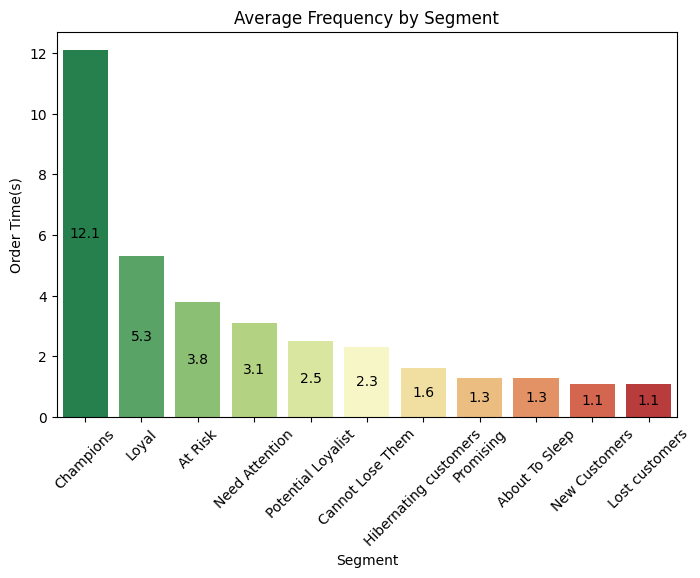

<ipython-input-54-e8e1933cfb4c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm['segment'], y=rfm[col], palette=color, legend = False)


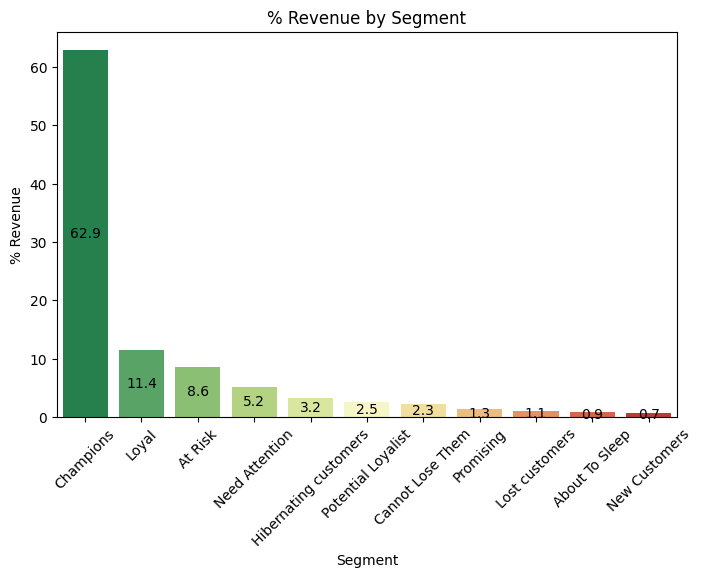

In [54]:
columns = ['avg_r', 'avg_f', '%_rvn']
titles = ['Average Recency by Segment', 'Average Frequency by Segment', '% Revenue by Segment']
y_labels = ['Day(s)', 'Order Time(s)', '% Revenue']

for i, col in enumerate(columns):
    rfm = rfm.sort_values(by=col, ascending=True if i == 0 else False)
    plt.figure(figsize=(8, 5))
    plt.title(titles[i])
    bars = plt.bar(rfm['segment'], rfm[col], alpha=0.7)
    sns.barplot(x=rfm['segment'], y=rfm[col], palette=color, legend = False)
    plt.bar_label(bars, label_type="center")
    plt.xlabel('Segment')
    plt.ylabel(y_labels[i])
    plt.xticks(rotation=45)
    plt.show()



> % of each segment in number of customer



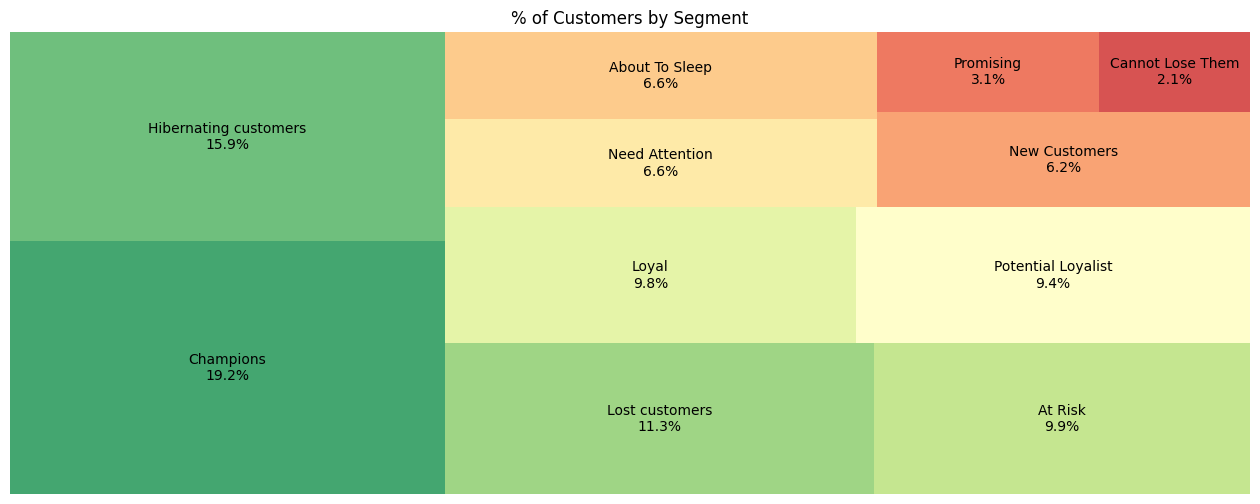

In [55]:
rfm = rfm.sort_values(by='%_ctm', ascending=False)
plt.figure(figsize=(16, 6))
labels_with_values = [f"{segment}\n{ctm:.1f}%" for segment, ctm in zip(rfm['segment'], rfm['%_ctm'])]
squarify.plot(sizes=rfm['%_ctm'], label=labels_with_values, color=color, alpha=0.8)
plt.title('% of Customers by Segment')
plt.axis('off')
plt.show()